# Scenario modeling with the Gravel Bedrock Eroder 

*B.C. Campforts, INSTAAR, University of Colorado Boulder* \
*V. Gabel, CIRES and Department of Geological Sciences, University of Colorado Boulder* \
*G.E. Tucker, CIRES and Department of Geological Sciences, University of Colorado Boulder* 

In the following notebook, we experiment with some scenarios demonstrating the use the of Gravel Bedrock Eroder component

# Scenario 1: 

In a first scenario, we compare the response time of a transient uplift pulse in BINTER and SPACE. 

In [191]:
# Import packages
import numpy as np
from landlab.components import (
    FlowAccumulator,
    PriorityFloodFlowRouter,
    DepressionFinderAndRouter,
    GravelBedrockEroder,
    SpaceLargeScaleEroder,
)
from landlab.plot import imshow_grid
from matplotlib import pyplot as plt
from landlab import RasterModelGrid

Create model function for BINTER

In [200]:
def run_BINTER(
    nr=3,
    nc=50,
    dx=500,
    dt=500,
    totT=2e7,
    transition_time=None,
    runoff_rate=10.0,
    runoff_rate_2=None,
    uplift_rate=1e-4,
    uplift_rate_2=None,
    coarse_fraction_from_plucking=0.0,
    intermittency_factor=0.03,
    plucking_coefficient=1e-6,
    transport_coefficient=0.041,
    abrasion_coefficient=0.0,
    sediment_porosity=0.1,
    depth_decay_scale=0.5,
    boundaries="open",
    uplift="bedrock",
    plot_iter=100,
):

    grid = RasterModelGrid((nr, nc), xy_spacing=dx)
    elev = grid.add_zeros("topographic__elevation", at="node")
    rock_elev = grid.add_zeros("bedrock__elevation", at="node")
    rock_elev[:] = np.random.rand(len(elev))
    sed = grid.add_zeros("soil__depth", at="node")
    sed[grid.core_nodes] = 0
    elev[:] = rock_elev + sed
    if boundaries == "single_outlet":
        grid.set_closed_boundaries_at_grid_edges(True, True, True, True)
        grid.set_watershed_boundary_condition_outlet_id(
            0, grid["node"]["topographic__elevation"], -9999.0
        )
        outlet_id = nc + 1
        # grid.status_at_node[0] = 1
    if boundaries == "one_face_open":
        grid.set_closed_boundaries_at_grid_edges(True, True, False, True)
        outlet_id = nc
    elif boundaries == "open":
        grid.set_closed_boundaries_at_grid_edges(False, False, False, False)

    fa = FlowAccumulator(grid, runoff_rate=runoff_rate, flow_director="D8")
    #     fa = PriorityFloodFlowRouter(grid, runoff_rate=runoff_rate, flow_metric = 'D8')
    # Instantiate depression finder and router; optional
    df = DepressionFinderAndRouter(grid)
    fa.run_one_step()

    eroder = GravelBedrockEroder(
        grid,
        abrasion_coefficient=abrasion_coefficient,
        plucking_coefficient=plucking_coefficient,
        intermittency_factor=intermittency_factor,
        transport_coefficient=transport_coefficient,
        sediment_porosity=sediment_porosity,
        depth_decay_scale=depth_decay_scale,
        coarse_fraction_from_plucking=coarse_fraction_from_plucking,
    )

    iterations = int(totT / dt)
    sed_flux_out = np.zeros(iterations)

    # Run model
    for ii in range(iterations):
        if transition_time is not None:
            if float((ii * dt)) >= transition_time:
                if uplift_rate_2 is not None:
                    uplift_rate = uplift_rate_2
                if runoff_rate_2 is not None:
                    fa = PriorityFloodFlowRouter(
                        grid, runoff_rate=runoff_rate_2, flow_metric="D8"
                    )

        if uplift == "bedrock":
            rock_elev[grid.core_nodes] += uplift_rate * dt
        elif uplift == "sediment":
            sed[grid.core_nodes] += uplift_rate * dt
        elev[grid.core_nodes] += uplift_rate * dt

        fa.run_one_step()
        # Run the depression finder and router; optional
        df.map_depressions()

        eroder.run_one_step(dt)
        if np.mod(ii, plot_iter) == 0:
            imshow_grid(
                grid,
                "topographic__elevation",
                plot_name="topographic__elevation",
                color_for_closed="white",
            )
            plt.title(ii / iterations)
            plt.show()
            print("%.02f percent of model run completed" % (ii / iterations))
        sed_flux_out[ii] = grid.at_node["bedload_sediment__volume_outflux"][outlet_id]

    return grid, sed_flux_out

Create model function for SPACE

In [ ]:
def run_SPACE(
    nr=3,
    nc=50,
    dx=500,
    dt=500,
    totT=2e7,
    transition_time=None,
    runoff_rate=10.0,
    runoff_rate_2=None,
    uplift_rate=1e-4,
    uplift_rate_2=None,
    K_sed=0.004,
    K_br=0.004,
    F_f=0.0,
    phi=0.3,
    H_star=0.1,
    v_s=1.0,
    v_s_lake=None,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0.0,
    sp_crit_br=0.0,
    boundaries="open",
    uplift="bedrock",
    plot_iter=100,
):

    grid = RasterModelGrid((nr, nc), xy_spacing=dx)
    elev = grid.add_zeros("topographic__elevation", at="node")
    rock_elev = grid.add_zeros("bedrock__elevation", at="node")
    rock_elev[:] = np.random.rand(len(elev))
    sed = grid.add_zeros("soil__depth", at="node")
    sed[grid.core_nodes] = 0
    elev[:] = rock_elev + sed
    if boundaries == "single_outlet":
        grid.set_closed_boundaries_at_grid_edges(True, True, True, True)
        grid.set_watershed_boundary_condition_outlet_id(
            0, grid["node"]["topographic__elevation"], -9999.0
        )
        outlet_id = nc + 1
        # grid.status_at_node[0] = 1
    if boundaries == "one_face_open":
        grid.set_closed_boundaries_at_grid_edges(True, True, False, True)
        outlet_id = nc
    elif boundaries == "open":
        grid.set_closed_boundaries_at_grid_edges(False, False, False, False)

    fa = FlowAccumulator(grid, runoff_rate=runoff_rate, flow_director="D8")
    # fa = PriorityFloodFlowRouter(grid, runoff_rate=runoff_rate, flow_metric = 'D8')

    # Instantiate depression finder and router; optional
    df = DepressionFinderAndRouter(grid)
    # fa.run_one_step()

    eroder = SpaceLargeScaleEroder(
        grid,
        K_sed=K_sed,
        K_br=K_br,
        F_f=F_f,
        phi=phi,
        H_star=H_star,
        v_s=v_s,
        v_s_lake=v_s_lake,
        m_sp=m_sp,
        n_sp=n_sp,
        sp_crit_sed=sp_crit_sed,
        sp_crit_br=sp_crit_br,
    )

    iterations = int(totT / dt)
    sed_flux_out = np.zeros(iterations)

    # Run model
    for ii in range(iterations):
        if transition_time is not None:
            if float((ii * dt)) >= transition_time:
                if uplift_rate_2 is not None:
                    uplift_rate = uplift_rate_2
                if runoff_rate_2 is not None:
                    fa = PriorityFloodFlowRouter(
                        grid, runoff_rate=runoff_rate_2, flow_metric="D8"
                    )

        if uplift == "bedrock":
            rock_elev[grid.core_nodes] += uplift_rate * dt
        elif uplift == "sediment":
            sed[grid.core_nodes] += uplift_rate * dt
        elev[grid.core_nodes] += uplift_rate * dt

        fa.run_one_step()
        # Run the depression finder and router; optional
        df.map_depressions()

        eroder.run_one_step(dt)
        if np.mod(ii, plot_iter) == 0:
            imshow_grid(
                grid,
                "topographic__elevation",
                plot_name="topographic__elevation",
                color_for_closed="white",
            )
            plt.title(ii / iterations)
            plt.show()
            print("%.02f percent of model run completed" % (ii / iterations))
        sed_flux_out[ii] = grid.at_node["sediment__flux"][outlet_id]

    return grid, sed_flux_out

Plotting functions 

In [153]:
def plot_model_results(grid, nc):

    elev = grid.at_node["topographic__elevation"]
    rock_elev = grid.at_node["bedrock__elevation"]
    sed = grid.at_node["soil__depth"]

    plt.plot(
        grid.x_of_node[nc : nc + nc - 1], elev[nc : nc + nc - 1], label="Elevation"
    )
    plt.plot(
        grid.x_of_node[nc : nc + nc - 1], rock_elev[nc : nc + nc - 1], label="Bedrock"
    )
    plt.plot(grid.x_of_node[nc : nc + nc - 1], sed[nc : nc + nc - 1], label="soil")
    plt.legend()
    plt.xlabel("Distance from mouth, m")
    plt.ylabel("Elevation, m")

    slope = grid.at_node["topographic__steepest_slope"]
    x = grid.x_of_node[nc + 1 : nc + nc - 1]
    slope_n = np.flip(slope[nc + 1 : nc + nc - 1])

    plt.figure()
    plt.plot(
        x,
        slope_n,
        label="slope",
        color="black",
        linewidth=3,
    )
    plt.legend()
    plt.xlabel("Distance from source, m")
    plt.ylabel("Slope, m/m")

    plt.figure()
    plt.plot(x, np.flip(elev[nc + 1 : nc + nc - 1]), color="black", label="Elevation")

    plt.legend()
    plt.xlabel("Distance from source, m")
    plt.ylabel("Elevation, m")


def plot_model_results_2D(
    grid,
    nc,
):

    elev = grid.at_node["topographic__elevation"]
    rock_elev = grid.at_node["bedrock__elevation"]
    sed = grid.at_node["soil__depth"]

    plt.figure()
    imshow_grid(grid, "soil__depth", plot_name="soil__depth", color_for_closed="white")
    plt.show()
    plt.figure()
    imshow_grid(
        grid,
        "bedrock__elevation",
        plot_name="bedrock__elevation",
        color_for_closed="white",
    )
    plt.show()
    plt.figure()
    imshow_grid(
        grid,
        "topographic__elevation",
        plot_name="topographic__elevation",
        color_for_closed="white",
    )
    plt.show()

    slope = grid.at_node["topographic__steepest_slope"]
    A = grid.at_node["drainage_area"]

    plt.figure()
    plt.scatter(
        A[grid.core_nodes],
        slope[grid.core_nodes],
        color="black",
        s=100,
        label="Numerical solution",
    )

    plt.xscale("log")
    plt.yscale("log")
    plt.legend()
    plt.xlabel("Area, m^2")
    plt.ylabel("Slope, m/m")

In [193]:
# 1. Binter model
coarse_fraction_from_plucking = 1.0
nr = 3
nc = 50
dx = 500
dt = 400
totT = 2e7
intermittency_factor = 0.03
runoff_rate = 1.0
plucking_coefficient = 8e-6
transport_coefficient = 0.041
abrasion_coefficient = 1 / 2000
sediment_porosity = 0.1
depth_decay_scale = 0.5
uplift_rate = 1e-4
boundaries == "one_face_open"


grid = run_BINTER(
    nr=nr,
    nc=nc,
    dx=dx,
    dt=dt,
    totT=totT,
    U=uplift_rate,
    coarse_fraction_from_plucking=coarse_fraction_from_plucking,
    intermittency_factor=intermittency_factor,
    runoff_rate=runoff_rate,
    plucking_coefficient=plucking_coefficient,
    transport_coefficient=transport_coefficient,
    abrasion_coefficient=abrasion_coefficient,
    sediment_porosity=sediment_porosity,
    depth_decay_scale=depth_decay_scale,
    boundaries=boundaries,
)

plot_model_results(grid, nc)

TypeError: run_BINTER() got an unexpected keyword argument 'U'

In [204]:
# 2. SPACE model
nr = 20
nc = 20
dx = 500
dt = 500
totT = 2e6
runoff_rate = 1.0
U = 1e-4
K_br = 2.1e-6
K_sed = K_br * 2
F_f = 0.5
phi = 0.3
H_star = 0.1
v_s = 1.0
v_s_lake = None
m_sp = 0.7  # 0.5
n_sp = 1.0
sp_crit_sed = 0.0
sp_crit_br = 0.0
# boundaries='one_face_open'
boundaries = "single_outlet"
uplift = "bedrock"


grid, sed_flux_out = run_SPACE(
    nr=nr,
    nc=nc,
    dx=dx,
    dt=dt,
    totT=totT,
    uplift_rate=U,
    runoff_rate=runoff_rate,
    K_sed=K_sed,
    K_br=K_br,
    F_f=F_f,
    phi=phi,
    H_star=H_star,
    v_s=v_s,
    v_s_lake=v_s_lake,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit_sed=sp_crit_sed,
    sp_crit_br=sp_crit_br,
    boundaries=boundaries,
    uplift=uplift,
)
plt.plot(sed_flux_out)

plt.figure()
plot_model_results(grid, nc)

TypeError: run_SPACE() got an unexpected keyword argument 'U'

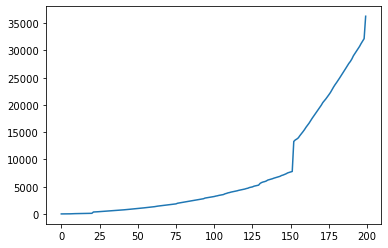

In [134]:
plt.plot(sed_flux_out)

### SPACE: Changing uplift 

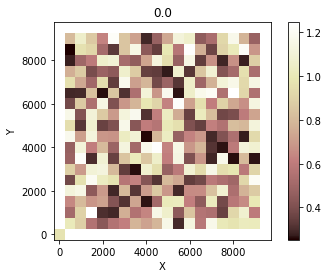

0.00 percent of model run completed


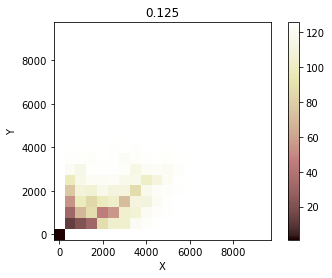

0.12 percent of model run completed


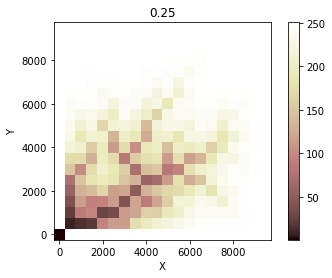

0.25 percent of model run completed


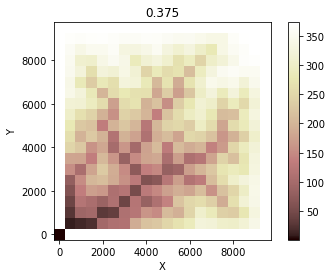

0.38 percent of model run completed


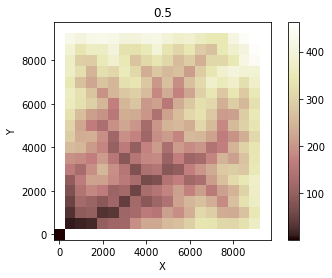

0.50 percent of model run completed


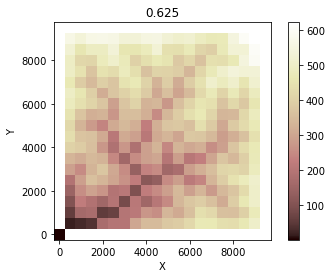

0.62 percent of model run completed


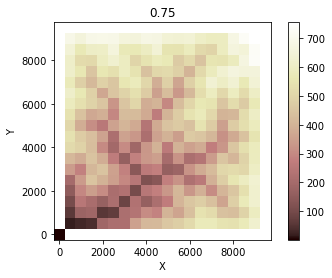

0.75 percent of model run completed


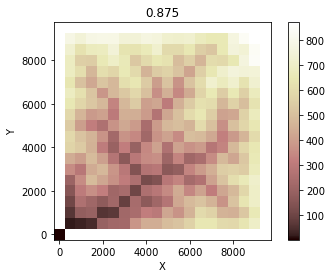

0.88 percent of model run completed


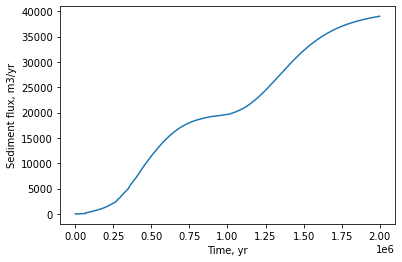

<Figure size 432x288 with 0 Axes>

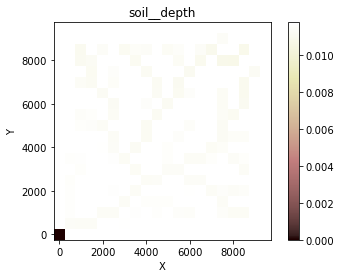

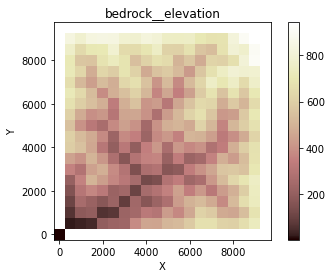

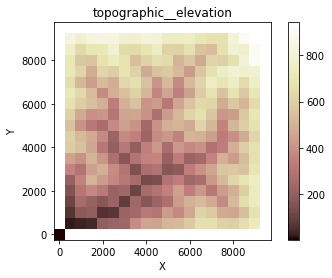

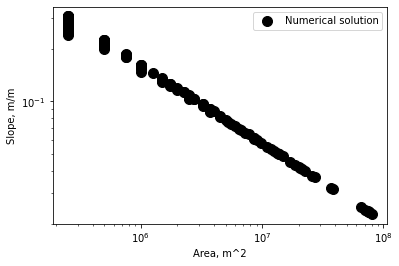

In [210]:
nr = 20
nc = 20
dx = 500
dt = 500
totT = 2e6
K_br = 1e-5  # 2.1e-6
K_sed = K_br * 2
F_f = 0.5
phi = 0.3
H_star = 0.1
v_s = 1.0
v_s_lake = None
m_sp = 0.45  # 0.5
n_sp = 1.0
sp_crit_sed = 0.0
sp_crit_br = 0.0
# boundaries='one_face_open'
boundaries = "single_outlet"
uplift = "bedrock"
plot_iter = 500

transition_time = 1e6
runoff_rate = 2.0
runoff_rate_2 = None
uplift_rate = 5e-4
uplift_rate_2 = 1e-3

grid, sed_flux_out = run_SPACE(
    nr=nr,
    nc=nc,
    dx=dx,
    dt=dt,
    totT=totT,
    transition_time=transition_time,
    uplift_rate=uplift_rate,
    runoff_rate=runoff_rate,
    uplift_rate_2=uplift_rate_2,
    runoff_rate_2=runoff_rate_2,
    K_sed=K_sed,
    K_br=K_br,
    F_f=F_f,
    phi=phi,
    H_star=H_star,
    v_s=v_s,
    v_s_lake=v_s_lake,
    m_sp=m_sp,
    n_sp=n_sp,
    sp_crit_sed=sp_crit_sed,
    sp_crit_br=sp_crit_br,
    boundaries=boundaries,
    uplift=uplift,
    plot_iter=plot_iter,
)
time_array = np.linspace(0, totT, int(totT / dt))
plt.plot(time_array, sed_flux_out)
plt.xlabel("Time, yr")
plt.ylabel("Sediment flux, m3/yr")

plt.figure()
plot_model_results_2D(grid, nc)

### Binter: Changing Uplift

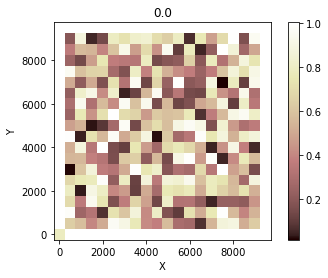

0.00 percent of model run completed


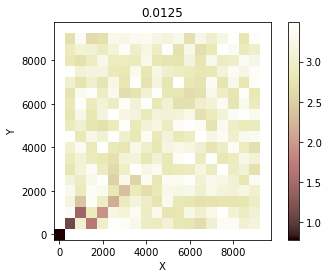

0.01 percent of model run completed


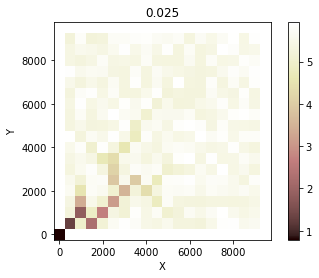

0.03 percent of model run completed


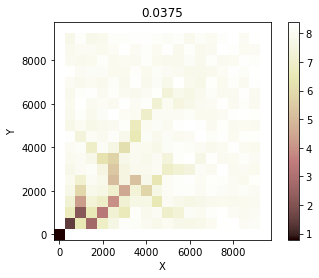

0.04 percent of model run completed


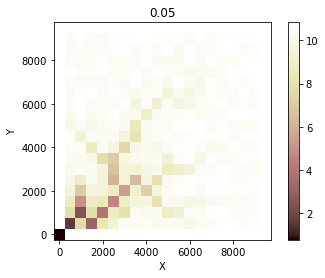

0.05 percent of model run completed


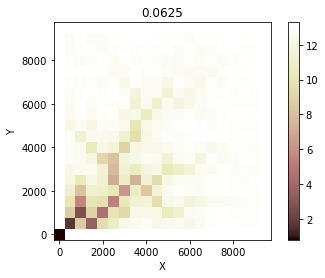

0.06 percent of model run completed


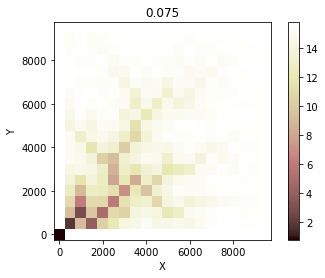

0.07 percent of model run completed


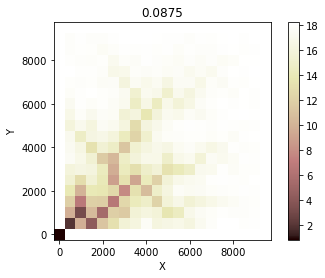

0.09 percent of model run completed


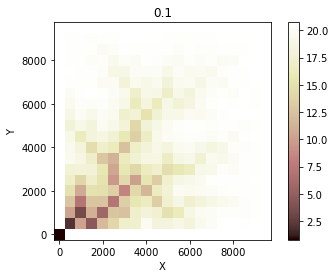

0.10 percent of model run completed


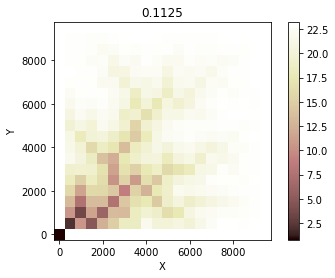

0.11 percent of model run completed


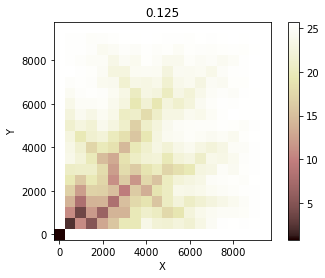

0.12 percent of model run completed


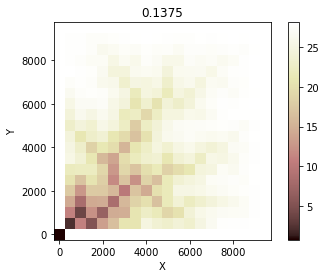

0.14 percent of model run completed


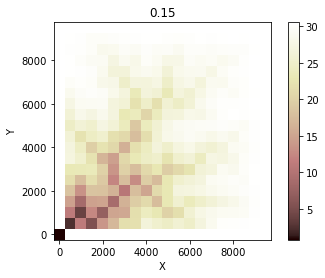

0.15 percent of model run completed


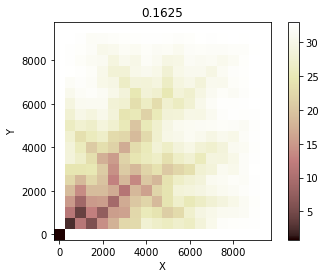

0.16 percent of model run completed


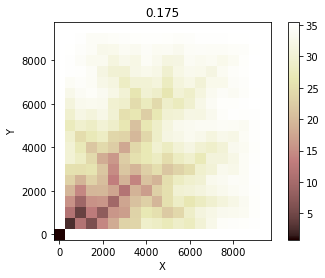

0.17 percent of model run completed


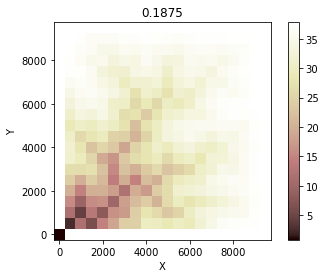

0.19 percent of model run completed


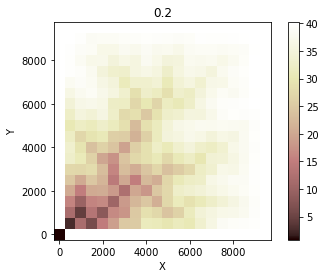

0.20 percent of model run completed


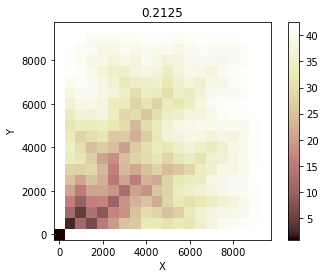

0.21 percent of model run completed


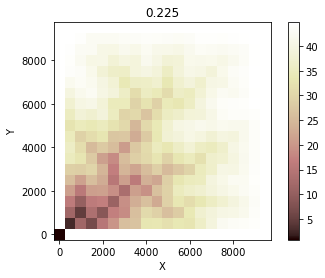

0.23 percent of model run completed


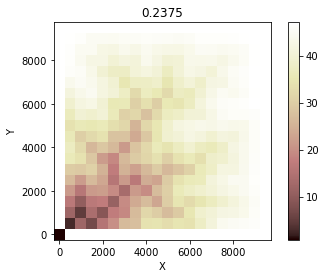

0.24 percent of model run completed


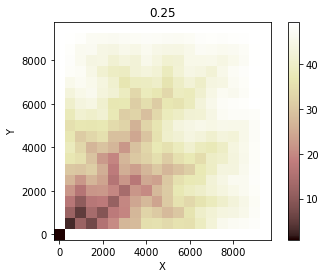

0.25 percent of model run completed


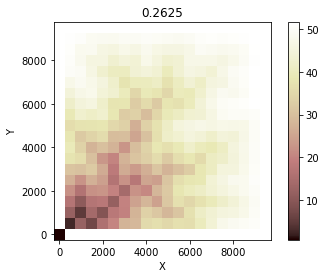

0.26 percent of model run completed


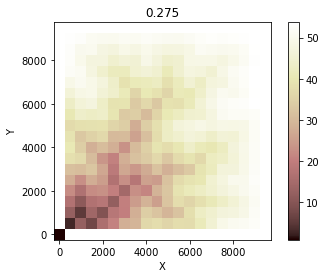

0.28 percent of model run completed


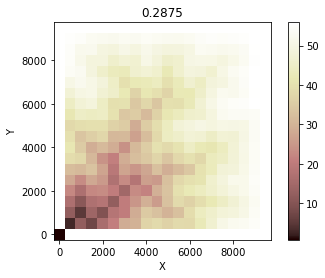

0.29 percent of model run completed


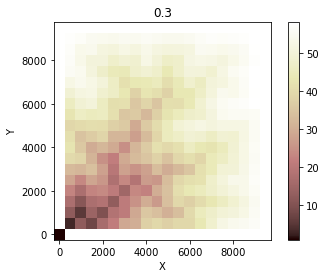

0.30 percent of model run completed


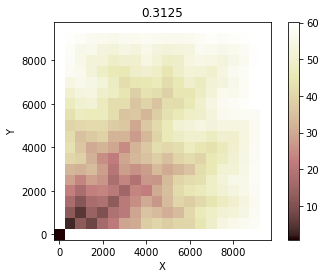

0.31 percent of model run completed


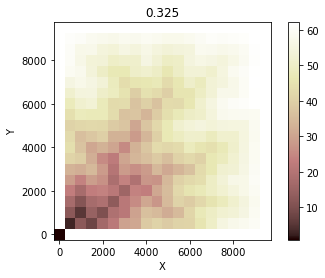

0.33 percent of model run completed


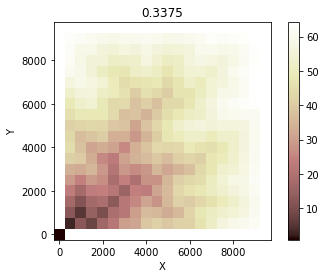

0.34 percent of model run completed


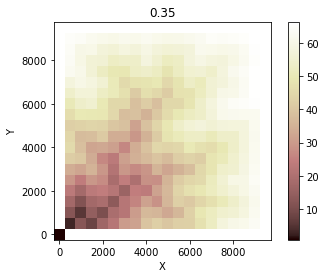

0.35 percent of model run completed


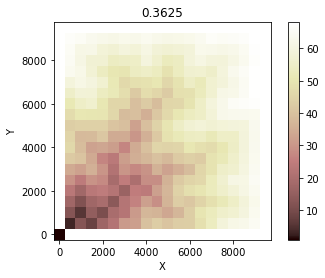

0.36 percent of model run completed


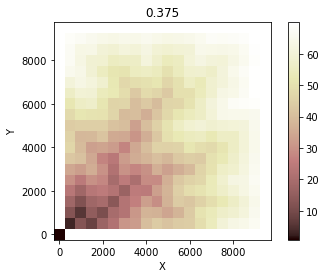

0.38 percent of model run completed


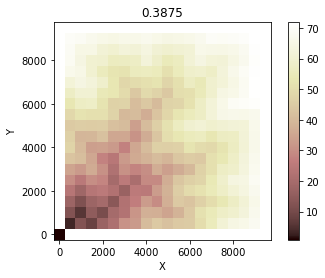

0.39 percent of model run completed


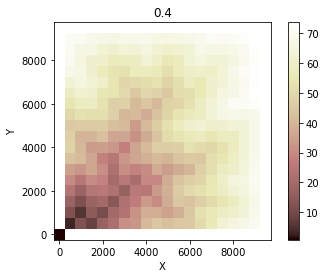

0.40 percent of model run completed


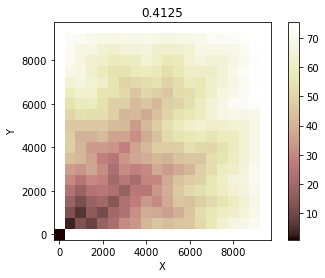

0.41 percent of model run completed


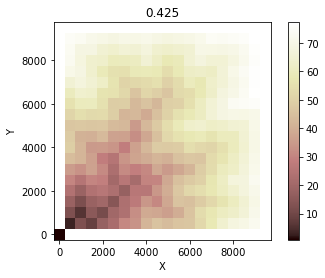

0.42 percent of model run completed


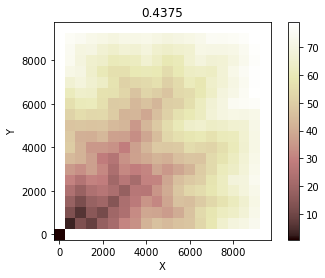

0.44 percent of model run completed


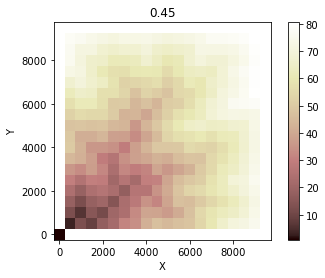

0.45 percent of model run completed


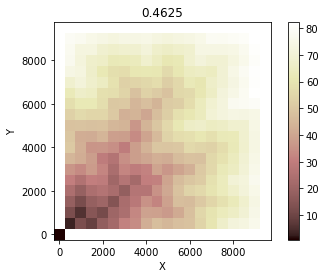

0.46 percent of model run completed


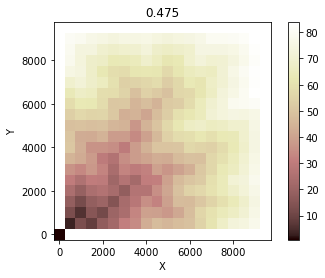

0.47 percent of model run completed


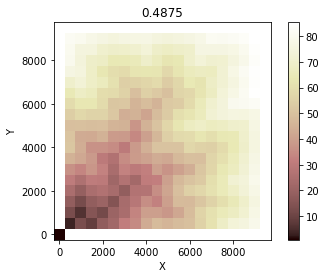

0.49 percent of model run completed


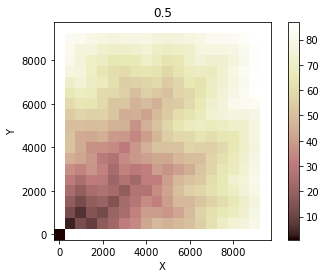

0.50 percent of model run completed


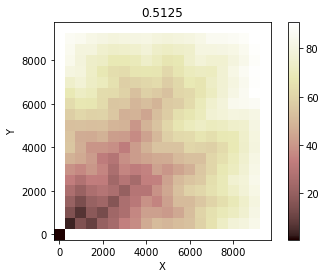

0.51 percent of model run completed


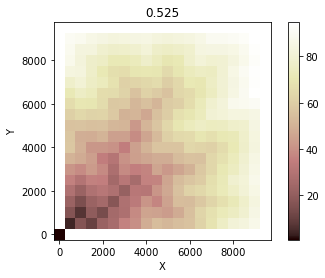

0.53 percent of model run completed


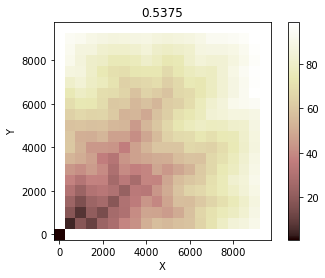

0.54 percent of model run completed


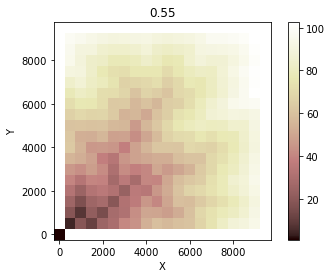

0.55 percent of model run completed


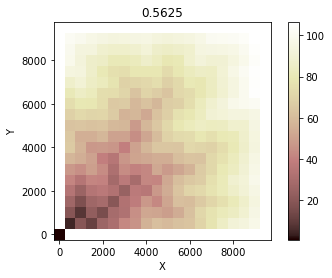

0.56 percent of model run completed


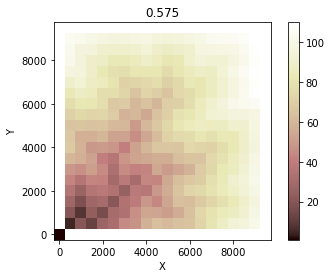

0.57 percent of model run completed


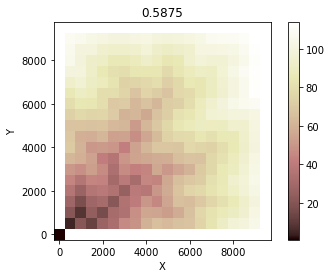

0.59 percent of model run completed


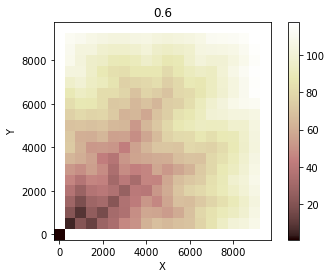

0.60 percent of model run completed


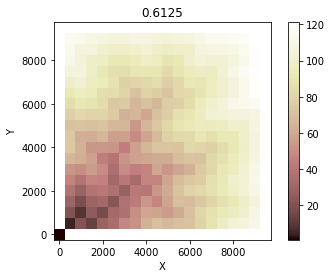

0.61 percent of model run completed


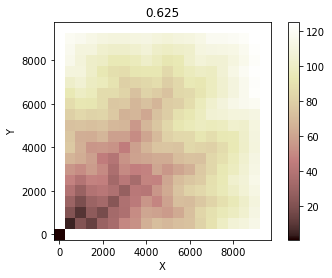

0.62 percent of model run completed


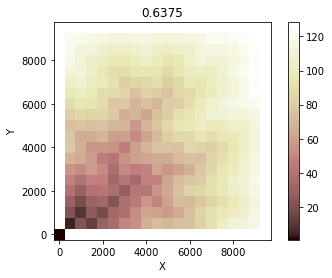

0.64 percent of model run completed


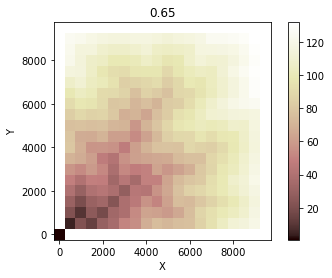

0.65 percent of model run completed


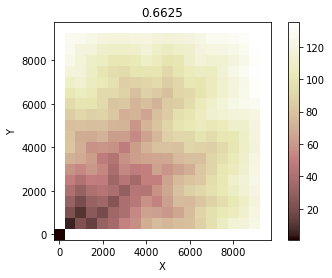

0.66 percent of model run completed


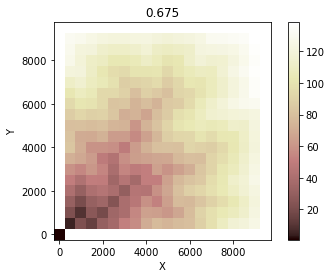

0.68 percent of model run completed


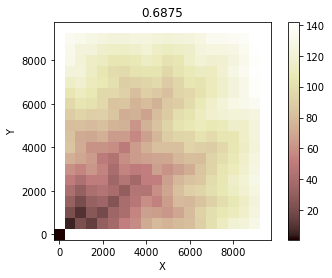

0.69 percent of model run completed


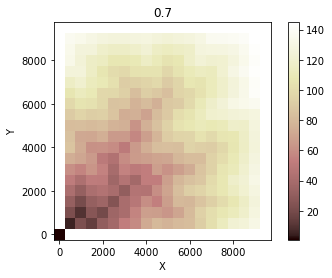

0.70 percent of model run completed


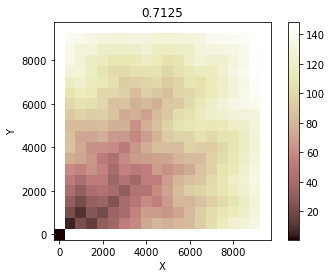

0.71 percent of model run completed


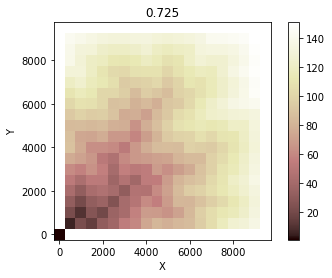

0.72 percent of model run completed


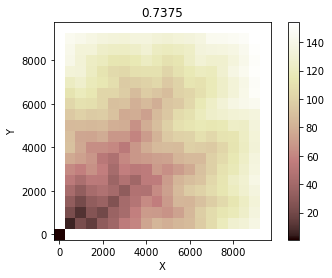

0.74 percent of model run completed


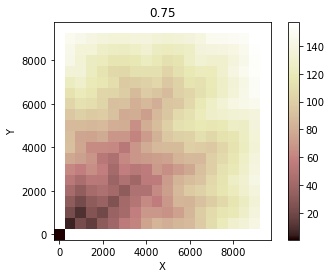

0.75 percent of model run completed


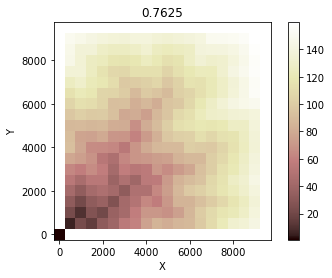

0.76 percent of model run completed


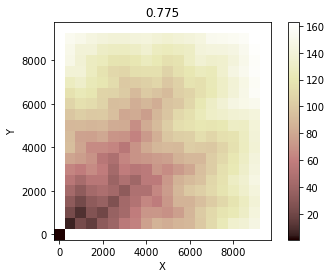

0.78 percent of model run completed


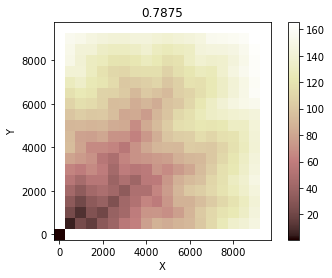

0.79 percent of model run completed


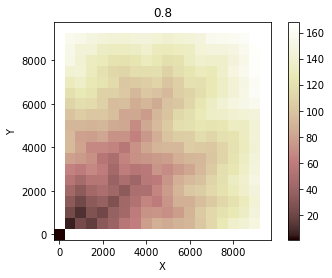

0.80 percent of model run completed


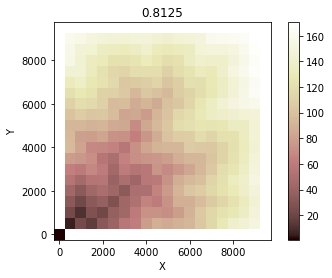

0.81 percent of model run completed


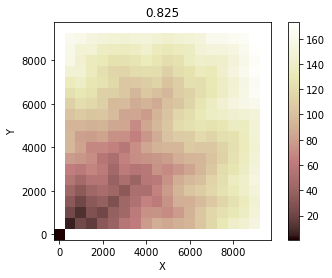

0.82 percent of model run completed


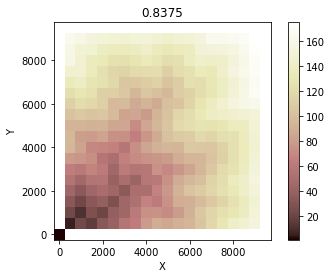

0.84 percent of model run completed


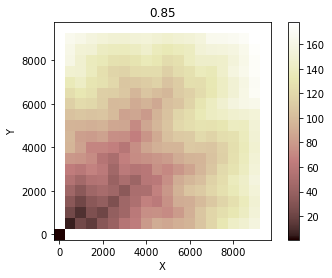

0.85 percent of model run completed


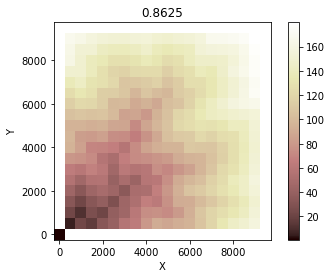

0.86 percent of model run completed


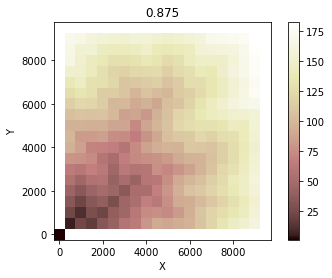

0.88 percent of model run completed


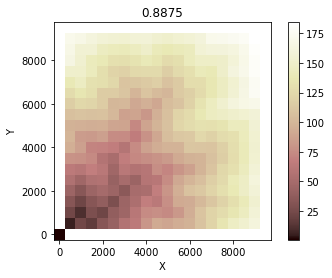

0.89 percent of model run completed


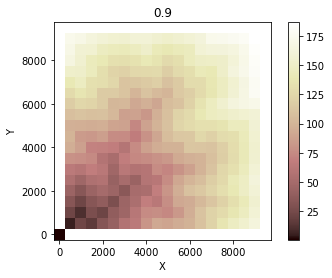

0.90 percent of model run completed


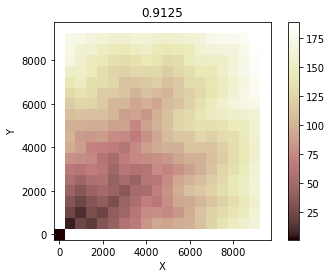

0.91 percent of model run completed


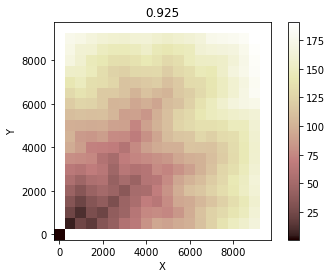

0.93 percent of model run completed


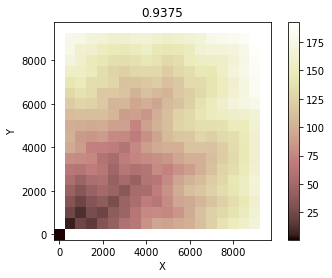

0.94 percent of model run completed


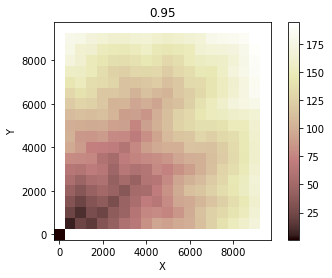

0.95 percent of model run completed


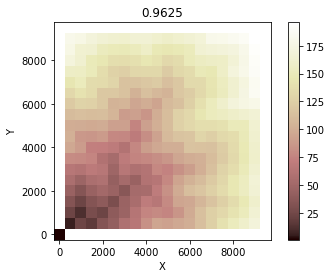

0.96 percent of model run completed


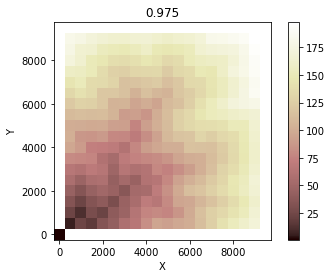

0.97 percent of model run completed


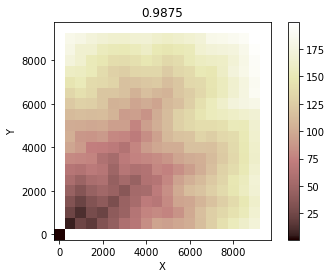

0.99 percent of model run completed


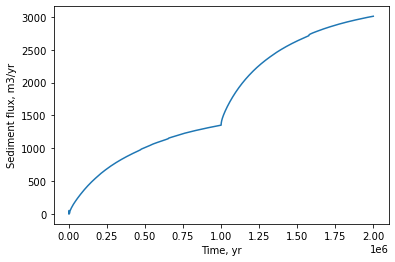

<Figure size 432x288 with 0 Axes>

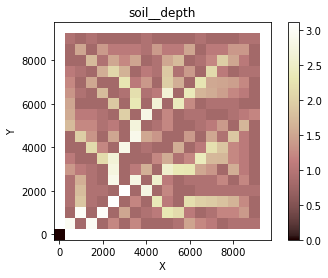

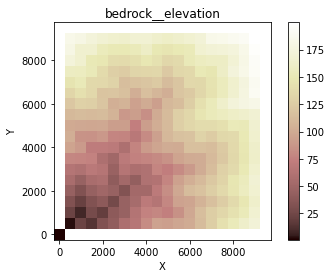

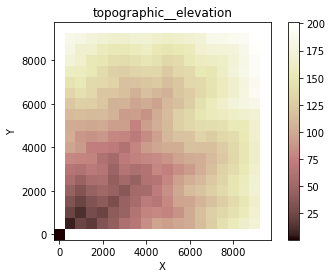

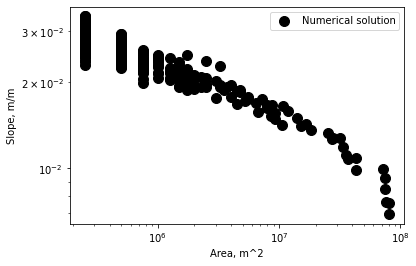

In [211]:
nr = 20
nc = 20
dx = 500
dt = 50
totT = 2e6
coarse_fraction_from_plucking = 1.0
intermittency_factor = 0.03
plucking_coefficient = 1e-5
transport_coefficient = 0.041
abrasion_coefficient = 1 / 5000
sediment_porosity = 0.1
depth_decay_scale = 0.5


# boundaries='one_face_open'
boundaries = "single_outlet"
uplift = "bedrock"
plot_iter = 500

transition_time = 1e6
runoff_rate = 10.0
runoff_rate_2 = None
uplift_rate = 1e-4
uplift_rate_2 = 2e-4

grid, sed_flux_BINTER_out = run_BINTER(
    nr=nr,
    nc=nc,
    dx=dx,
    dt=dt,
    totT=totT,
    transition_time=transition_time,
    runoff_rate=runoff_rate,
    runoff_rate_2=runoff_rate_2,
    uplift_rate=uplift_rate,
    uplift_rate_2=uplift_rate_2,
    coarse_fraction_from_plucking=coarse_fraction_from_plucking,
    intermittency_factor=intermittency_factor,
    plucking_coefficient=plucking_coefficient,
    transport_coefficient=transport_coefficient,
    abrasion_coefficient=abrasion_coefficient,
    sediment_porosity=sediment_porosity,
    depth_decay_scale=depth_decay_scale,
    boundaries=boundaries,
    uplift=uplift,
    plot_iter=plot_iter,
)

time_array = np.linspace(0, totT, int(totT / dt))
plt.plot(time_array, sed_flux_BINTER_out)
plt.xlabel("Time, yr")
plt.ylabel("Sediment flux, m3/yr")

plt.figure()
plot_model_results_2D(grid, nc)